# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
      - [Conclusion - City with highest number of trips](#sc1)
      - [Conclusion - Trip Length](#sc2)
      - [Conclusion - Subscriber vs Consumer riding time ](#sc3)
  - [Visualizations](#visualizations)
- [Performing Further Analysis - Chicago](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I perform perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I compare the system usage between three large cities: New York City, Chicago, and Washington, DC. I'll also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, I need to start by asking questions I want to understand about the bike share data. I ask a few questions below and in the rest of the analysis I'll try to answer them.

**Question 1**: Which days have the highest customer traffic at the bike rental stations?

**Question 2**: Which cities have the highest number of bike users?

**Question 3**: Which cities has the highest number of repeat customers?

**Question 4**: How long do the people ride on average, by day of week?

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

The data has already been collected in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. A random 2% sample of the original data is taken to make the exploration more manageable.

I'll start off by looking at the dataset available. Below I use the functions available in Python, such as **pprint()** instead of using Pandas **dataframe**, just as an example.

In [14]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
import statistics

In [15]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        ## Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        
        ## Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

The above printout shows that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we need to trim and clean the data.

I'll generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


**Helper functions**: Below are a few helper functions to address each of the cleaning tasks described above.

In [16]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    """
    trip_duration = 0
    
    if city=='Chicago':
        trip_duration = float(datum['tripduration'])
        trip_duration_min = trip_duration/60
    elif city=='NYC':
        trip_duration = float(datum['tripduration'])
        trip_duration_min = trip_duration/60   
    else:
        trip_duration_ms = float(datum['Duration (ms)'])
        trip_duration_min = trip_duration_ms/(60*1000)

    return trip_duration_min


# Some tests to check that your code works.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231,
         }

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

Nothing prints; the tests passed. Now making some more helper functions.

In [17]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    
    if city=='Chicago': #'3/31/2016 23:30'
        time_string = datum['starttime']
        #print(time_string)
        time_obj = datetime.strptime(time_string, "%m/%d/%Y %H:%M")
        
        month = int(time_obj.strftime("%m"))
        hour = int(time_obj.strftime("%H"))
        day_of_week = time_obj.strftime("%A")
        
        #print(month, hour, day_of_week)
               
    elif city=='NYC': #'1/1/2016 00:09:55'
        time_string = datum['starttime']
        #print(time_string)
        time_obj = datetime.strptime(time_string, "%m/%d/%Y %H:%M:%S")
        
        month = int(time_obj.strftime("%m"))
        hour = int(time_obj.strftime("%H"))
        day_of_week = time_obj.strftime("%A")
        
        #print(month, hour, day_of_week)
    else: #'3/31/2016 22:57'
        time_string = datum['Start date']
        #print(time_string)
        time_obj = datetime.strptime(time_string, "%m/%d/%Y %H:%M")
        
        month = int(time_obj.strftime("%m"))
        hour = int(time_obj.strftime("%H"))
        day_of_week = time_obj.strftime("%A")
        
        #print(month, hour, day_of_week)
  
    return (month, hour, day_of_week)


# Assertion tests
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

#time_of_trip(example_trips['Washington'], 'Washington')

In [18]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    if city=='Chicago':
        user_type = datum['usertype']
        #print(user_type)
    elif city=='NYC':
        user_type = datum['usertype']
        #print(user_type)
    else:
        user_type = datum['Member Type']
        if user_type == 'Registered':
            user_type = 'Subscriber'
        else:
            user_type = 'Customer'
            
        #print(user_type)
    return user_type


# Assertion Tests
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

Below I'll use the helper functions above to create a condensed data file for each city consisting only of the data fields indicated above.

In [19]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## set up csv DictReader object ##
        ##in_colnames - ['trip_id','starttime','stoptime','bikeid','tripduration','from_station_id','from_station_name',
        ##               'to_station_id','to_station_name','usertype','gender','birthyear']
        trip_reader = csv.DictReader(f_in)


        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## use the helper functions to get the cleaned data from        ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            duration = duration_in_mins(row, city)
            month, hour, day_of_week = time_of_trip(row, city)
            user_type = type_of_user(row, city)
            
            new_point['duration'] = duration
            new_point['month'] = month
            new_point['hour'] = hour
            new_point['day_of_week'] = day_of_week
            new_point['user_type'] = user_type
           
            ## write the processed information to the output file.           ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)
            
        

In [20]:
# Verifying the data extracted
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now onto exploring the data using some visualizations.
<a id='statistics'></a>
### Statistics

We'll answer the following basic questions:

- Which city has the highest number of trips? 
- Which city has the highest proportion of trips made by subscribers? 
- Which city has the highest proportion of trips made by short-term customers?

In [21]:
def number_of_trips(filename, city_name):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        proportion_rides_customers = n_customers/n_total
        proportion_rides_subscribers = n_subscribers/n_total
        
        print("City: {}".format(city_name))
        print("Total rides: \t\t\t{}".format(n_total))
        print("Subscriber rides: \t\t{}".format(n_subscribers))
        print("Customer rides: \t\t{}".format(n_customers))
        print("% of customer rides: \t\t{0:.2f}".format(proportion_rides_customers*100)) # rounding off to two digits
        print("% of subscriber rides: \t\t{0:.2f}".format(proportion_rides_subscribers*100))
        
        # return tallies as a tuple
        #return(n_subscribers, n_customers, n_total)

In [23]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##

data_file = './data/Chicago-2016-Summary.csv'
number_of_trips(data_file, "Chicago")

City: Chicago
Total rides: 			72131
Subscriber rides: 		54982
Customer rides: 		17149
% of customer rides: 		23.77
% of subscriber rides: 		76.23


In [24]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##

data_file = './data/NYC-2016-Summary.csv'
number_of_trips(data_file, "NYC")

City: NYC
Total rides: 			276798
Subscriber rides: 		245896
Customer rides: 		30902
% of customer rides: 		11.16
% of subscriber rides: 		88.84


In [25]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##

data_file = './data/Washington-2016-Summary.csv'
number_of_trips(data_file, "Washington")

City: Washington
Total rides: 			66326
Subscriber rides: 		51753
Customer rides: 		14573
% of customer rides: 		21.97
% of subscriber rides: 		78.03


<a id='sc1'></a>
### Conclusion - City with highest number of trips
- City with the highest number of trips: **NYC**
- City with the highest proportion of trips made by subscribers: **NYC**
- City has the highest proportion of trips made by short-term customers: **Chicago**
- Customer trip proportion by city
   
   NYC: 11.16%<br> Chicago: 23.77%<br>Washington: 21.97%<br>

### Question - Trip Length ###
Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

In [26]:
def average_trip_length(filename):
    """
    This function reads in a file with trip data and reports the
    average duration in minutes of all the trips made in the city. It
    also returns the proportion of trips longer than 30 minutes
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        number_of_trips = 0
        total_duration_all_trips = 0
        long_trips = 0
        
        # count the total number of trips 
        # and get the total duration of trips
        for row in reader:
            duration_trip = float(row['duration'])
            total_duration_all_trips += duration_trip
            number_of_trips += 1
            
            if duration_trip>30:
                long_trips += 1
        
        avg_trip_time = total_duration_all_trips/number_of_trips
        long_trips_percent = (long_trips/number_of_trips)*100
        
        # return tallies as a tuple
        return(avg_trip_time, long_trips_percent)

In [29]:
data_file_Chicago = './data/Chicago-2016-Summary.csv'
data_file_NYC = './data/NYC-2016-Summary.csv'
data_file_Washington = './data/Washington-2016-Summary.csv'

print(average_trip_length(data_file_Chicago))
print(average_trip_length(data_file_NYC))
print(average_trip_length(data_file_Washington))

(16.563629368787335, 8.332062497400562)
(15.81259299802294, 7.3024371563378345)
(18.93287355913721, 10.83888671109369)


<a id='sc2'></a>
### Conclusion - Trip Length ###

Average trip length for the city and percentage of trips over 30 min
- Chicago: 16.56 minutes, 8.33%, 
- NYC: 15.81 minutes, 7.30%, 
- Washington: 18.93 minutes, 10.84%

### Question - Subscriber vs Customer riding time###
I want to investigate which type of user takes longer rides on average: Subscribers or Customers?

In [30]:
def subscriber_vs_customer(filename):
    """
    This function reads in a file with trip data and reports the average
    duration in minutes of all the trips made by subscribers vs customers
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        total_customer_trips_duration = 0
        total_subscriber_trips_duration = 0
        number_of_customer_trips = 0
        number_of_subscriber_trips = 0
        
        # count the total number of trips 
        for row in reader:
            duration_trip = float(row['duration'])
            if row['user_type'] == 'Subscriber':
                total_customer_trips_duration += duration_trip
                number_of_customer_trips += 1
            else:
                total_subscriber_trips_duration += duration_trip
                number_of_subscriber_trips += 1

        # calculate avg customer and avg subscriber trip durations
        avg_customer_trip_duration = total_customer_trips_duration/number_of_customer_trips
        avg_subscriber_trip_duration = total_subscriber_trips_duration/number_of_subscriber_trips
        
        # return tallies as a tuple
        return(avg_customer_trip_duration, avg_subscriber_trip_duration)


In [31]:
data_file_Chicago = './data/Chicago-2016-Summary.csv'
data_file_NYC = './data/NYC-2016-Summary.csv'
data_file_Washington = './data/Washington-2016-Summary.csv'

print(subscriber_vs_customer(data_file_Chicago))
print(subscriber_vs_customer(data_file_NYC))
print(subscriber_vs_customer(data_file_Washington))

(12.067201690250076, 30.979781133982506)
(13.680790523907177, 32.77595139473187)
(12.528120499294745, 41.67803139252976)


<a id='sc3'></a>
### Conclusion - Subscriber vs Consumer riding time ###
Chicago: Subscriber takes longer rides(31 min) on average than customer does(12 min)
NYC: Subscriber takes longer rides(33 min) on average than customer does(14 min)
Washington: Subscriber takes longer rides(41 min) on average than customer does(13 min)

We can conclude from the above observations that generally subscribers take longer rides than customers. This conclusion can impact business decisions. For example, the company might want to offer extra incentive to customers to subscribe to the service, or it might want to investigate this trend further to check correlation between riding time and user status.

<a id='visualizations'></a>
### Visualizations
Here is an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. 

In [45]:
# load library
import matplotlib.pyplot as plt

%matplotlib inline 

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

You will now use these functions to create a histogram of the trip times for the city you selected in question 4c. Don't separate the Subscribers and Customers for now: just collect all of the trip times and plot them.

In [48]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##

def plot_trip_duration(filename):
    """
    This function takes in a csv file and parses the
    trip_duration into a list. It then takes the list
    and generates a histogram of trip times
    """
    trip_duration_list = []
    
    with open(filename, 'r') as f_in:
        # read the file into a dictionary
        reader = csv.DictReader(f_in)
        
        for row in reader:
            # get duration from the row, convert
            # it to float and add it to the list
            trip_duration = float(row['duration'])
            trip_duration_list.append(trip_duration)
    
    plt.hist(trip_duration_list)
    plt.title('Distribution of Trip Durations for Chicago')
    plt.xlabel('Duration (minutes)')
    plt.show()

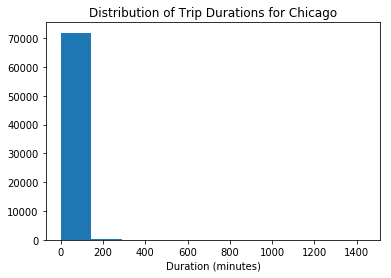

None


In [49]:
data_file_Chicago = './data/Chicago-2016-Summary.csv'

print(plot_trip_duration(data_file_Chicago))

The plot here suggests that there are some highly infrequent outliers in the data. I'll try to plot the graph again adding limits to the plots. Here I'll plot the graph for Customers and Subscribers for duration less than 75 min. I am setting the bars to five minute intervals for better analysis.

In [64]:
def plot_trip_duration_subscribers_customers(filename):
    """
    This function takes in a csv file and parses the
    trip_duration into a list. It then takes the list
    and generates a histogram of trip times
    """
    trip_duration_list_subscribers = []
    trip_duration_list_customers = []
    
    with open(filename, 'r') as f_in:
        # read the file into a dictionary
        reader = csv.DictReader(f_in)
        
        for row in reader:
            # get duration from the row, convert
            # it to float and add it to the list
            trip_duration = float(row['duration'])
            if row['user_type'] == "Subscriber":
                trip_duration_list_subscribers.append(trip_duration)
            else:
                trip_duration_list_customers.append(trip_duration)
      
    plt.hist(trip_duration_list_subscribers, range(0,75,5))
    plt.title('Distribution of Subscribers Trip Durations for Chicago')
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Number of trips')
    plt.show();

    plt.hist(trip_duration_list_customers, range(0,75,5))
    plt.title('Distribution of Customers Trip Durations for Chicago')
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Number of trips')
    plt.show();


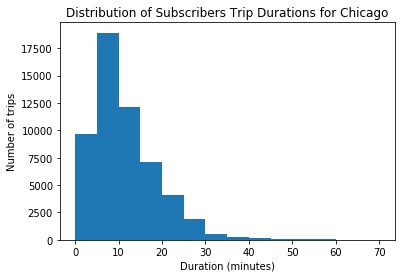

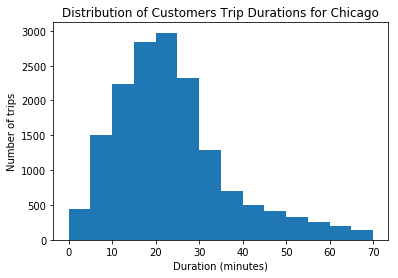

None


In [65]:
data_file_Chicago = './data/Chicago-2016-Summary.csv'

print(plot_trip_duration_subscribers_customers(data_file_Chicago));

### Conclusion ##
For Subscribers the peak is between 5 and 10; for customers the peak is between 20 and 25. In both cases the graph is skewed to the right. For subscribers the majority trips were over 10 minutes while for customers the majority of the trips were over 25 minutes.

<a id='eda_continued'></a>
## Performing Further Analysis - Chicago ##

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

In [66]:
## Use this and additional cells to continue to explore the dataset. ##
## Once you have performed your exploration, document your findings  ##
## in the Markdown cell above.                                       ##

def get_ridership_by_month_and_day_of_week(filename):
    """
    This function takes in a csv file and counts
    the trips grouped by month. It then generates
    a bar graph of the trips
    """
    month_count_dict_customer = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
    month_count_dict_subscriber = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
    
    week_count_dict_customer = {'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':0,'Sunday':0}
    week_count_dict_subscriber = {'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':0,'Sunday':0}
    
    with open(filename, 'r') as f_in:
        # read the file into a dictionary
        reader = csv.DictReader(f_in)
        
        for row in reader:
            # get month from the row and
            # add it to the dictionary
            trip_month = int(row['month'])
            trip_day_of_week = row['day_of_week']

            if row['user_type'] == "Subscriber":
                month_count_dict_subscriber[trip_month] += 1
                week_count_dict_subscriber[trip_day_of_week] += 1
            else:
                month_count_dict_customer[trip_month] += 1
                week_count_dict_customer[trip_day_of_week] += 1
    
    # plotting monthly trip counts by subscriber and customer
    plot_bar_from_dict(month_count_dict_subscriber,'Monthly','Subscriber')
    plot_bar_from_dict(month_count_dict_subscriber,'Monthly','Customer')
    
    # plotting weekly trip counts by subscriber and customer
    plot_bar_from_dict(week_count_dict_subscriber,'Weekly','Subscriber')
    plot_bar_from_dict(week_count_dict_customer,'Weekly','Customer')

    

def plot_bar_from_dict(dict_month,duration,user_type):
    #plot the list using a histogram
    %matplotlib inline

    title = "Distribution of {} {} Trip Durations for Chicago".format(duration, user_type)
    plt.bar(dict_month.keys(), dict_month.values())
    plt.title(title)
    plt.xlabel(duration.title()) # capitalize the duration
    plt.show()
    

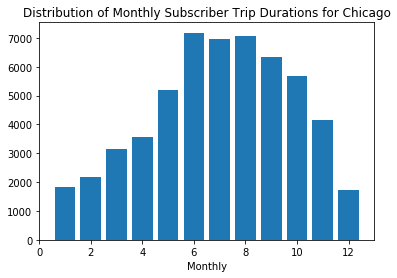

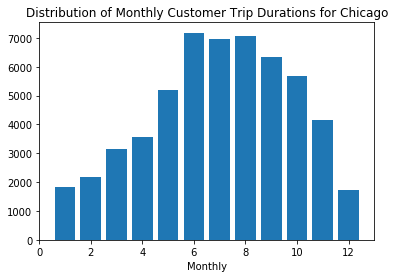

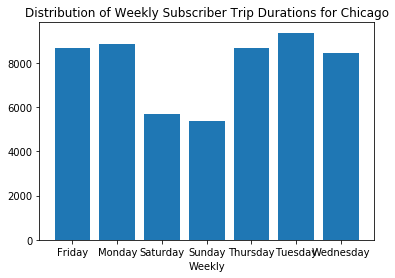

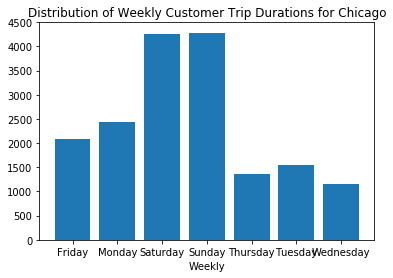

None


In [67]:
data_file_Chicago = './data/Chicago-2016-Summary.csv'

print(get_ridership_by_month_and_day_of_week(data_file_Chicago))

<a id='conclusions'></a>
### Conclusions - Chicago
#### Monthly trip duration analysis for subscriber and customers
Maximum trips are in Summer, peaking in June, for both customers and subscribers. December and January record the lowest number of trips for both categories

#### Weekly trip duration analysis for subscriber and customers
Subscribers take a markedly higher number of trips during the weekdays while customers take theor major share of trips during the weekends